<a href="https://colab.research.google.com/github/ReylordDev/nn-zero-to-hero-exercises/blob/master/lectures/makemore/part2/build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# If running from colab:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/ReylordDev/nn-zero-to-hero-exercises/master/lectures/makemore/names.txt

In [16]:
# change path to 'names.txt' if running in colab
words = open('../names.txt', 'r').read().splitlines()

In [17]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [18]:
train_split_index = int(len(words)*0.8)
dev_split_index = int(len(words)*0.9)

In [ ]:
experiments = []

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
embedding_dimensions = 10 # how many dimensions should the projected space of the characters have?
layer1_size = 200 # how many neurons should the first layer have? Layer 2 will have the same number of neurons to match dimensions.
training_steps = 30000 # how many training steps should we take?
minibatch_size = 32 # how many examples should we use to update the weights at each step?


In [19]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:train_split_index])
Xdev, Ydev = build_dataset(words[train_split_index:dev_split_index])
Xte, Yte = build_dataset(words[dev_split_index:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [20]:
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility
C = torch.randn((27, embedding_dimensions), generator=g, device=device)
W1 = torch.randn((block_size * embedding_dimensions, layer1_size), generator=g, device=device)
b1 = torch.randn(layer1_size, generator=g, device=device)
W2 = torch.randn((layer1_size, 27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)
parameters = [C, W1, b1, W2, b2]

In [21]:
n_parameters = sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [22]:
for p in parameters:
  p.requires_grad = True

In [23]:
# learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [24]:
lri = []
lossi = []
stepi = []

In [25]:

for i in range(training_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (minibatch_size,), device=device)
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, block_size * embedding_dimensions) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < (training_steps / 2) else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [27]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
training_loss = loss.item()
loss

tensor(4.0595, grad_fn=<NllLossBackward0>)

In [28]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
validation_loss = loss.item()
loss

tensor(4.0495, grad_fn=<NllLossBackward0>)

In [ ]:
hyperparameters = {}
hyperparameters['block_size'] = block_size
hyperparameters['embedding_dimensions'] = embedding_dimensions
hyperparameters['layer1_size'] = layer1_size
hyperparameters['training_steps'] = training_steps
hyperparameters['minibatch_size'] = minibatch_size
hyperparameters['learning_rate'] = lr
hyperparameters['training_loss'] = loss.item()
hyperparameters['validation_loss'] = loss.item()
experiments.append(hyperparameters)

In [ ]:
experiments

In [29]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
test_loss = loss.item()
test_loss

tensor(4.1042, grad_fn=<NllLossBackward0>)

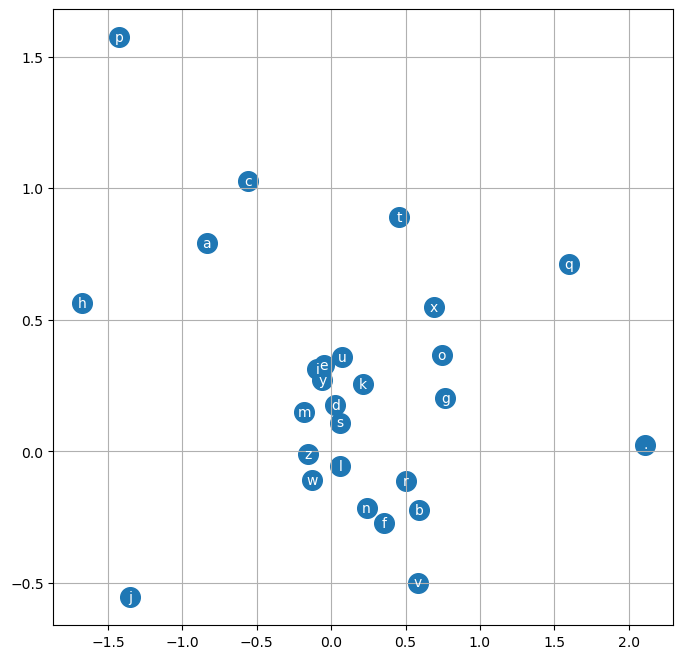

In [30]:
if torch.cuda.is_available():
    C = C.cpu()
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# this doesn't make sense for more than 2 dimensions of embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

if torch.cuda.is_available():
    C = C.cuda()

In [31]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cana.
hftuoalmsnscellexzaltishannasa.
jaroner.
aplisat.
kabbuxtkyjkego.
maiir.
kalaeny.
hai.
jory.
qha.
teoa.
jora.
james.
wamara.
deviyn.
kabbuxturuyn.
emceklia.
gyn.
ley.
riilahae.
